In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd

In [2]:
req= [(7, 1),(8, 1),(7, 2),(7, 3),(7, 4),(15, 6),(13, 8),(15, 8)
,(18, 9),(19, 9),(20, 9),(16, 10),(17, 10),(19, 12),(19, 14),(21, 16),(22, 16),(24, 16),(21, 17)
,(25, 17),(26, 17),(28, 17),(23, 18),(26, 18),(27, 19),(28, 19),(25, 20),(27, 20),(32, 21),(29, 22)
,(30, 22),(32, 22),(29, 23),(32, 23),(29, 24),(30, 24)
,(31, 24),(29, 25),(32, 25),(31, 26),(29, 27),(30, 27),(31, 27),(30, 28),(32, 28)
,(33, 29),(34, 29),(35, 29),(33, 31),(36, 31),(37, 31),(36, 32),(41, 33),(44, 33),(45, 33),(39, 34),(40, 35),(39, 36),(42, 37),(44, 37),(45, 37)
,(40, 38),(41, 38),(43, 38),(44, 38),(47, 39),(46, 41),(47, 41),(47, 42),(49, 47)]

In [3]:
n_courses = 50
n_periods = 10
load_per_period_lb = 2
load_per_period_ub = 100
courses_per_period_lb = 2
courses_per_period_ub = 10
course_load = [3, 7, 6, 1, 3, 2, 5, 1, 7, 10, 4, 9, 9, 10, 6, 8, 4, 1, 10, 9, 8, 5, 10, 5, 9, 4, 1, 3, 3, 3, 2, 8, 9, 9, 8, 4, 10, 2, 4, 8, 1, 7, 7, 1, 8, 2, 10, 4, 4, 9, ]
len(course_load)

50

In [4]:
model = AbstractModel()
model.i = RangeSet(n_courses)
model.t = RangeSet(n_periods)
model.dependency = Set(initialize=req)
model.assign = Var(model.i, model.t, initialize = 0, within=Binary)
model.maxload = Var(bounds=(0,100), initialize = 0, within=Reals)

def rule_load(model,i):
    return course_load[i-1]
model.L = Param(model.i, initialize = rule_load)

def Rule_C0(model,i1,i2 ):
    return sum(tt*model.assign[i1,tt] for tt in model.t) <= sum(tt*model.assign[i2,tt] for tt in model.t)
model.C0=Constraint(model.dependency, rule=Rule_C0)

def Rule_C1(model,i):
    return sum(model.assign[i,t] for t in model.t) == 1
model.C1=Constraint(model.i, rule=Rule_C1)

def Rule_C2A(model,t):
    return sum(model.assign[i,t] for i in model.i) <= courses_per_period_ub
model.C2A=Constraint(model.t, rule=Rule_C2A)

def Rule_C2AL(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) <= load_per_period_ub
model.C2AL=Constraint(model.t, rule=Rule_C2AL)

def Rule_C2B(model,t):
    return sum(model.assign[i,t] for i in model.i) >= courses_per_period_lb
model.C2B=Constraint(model.t, rule=Rule_C2B)

def Rule_C2BL(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) >= load_per_period_lb
model.C2BL=Constraint(model.t, rule=Rule_C2BL)

def Rule_C3(model,t):
    return sum(model.L[i]* model.assign[i,t] for i in model.i) <= model.maxload
model.C3=Constraint(model.t, rule=Rule_C3)

def rule_OF(model):
    #return model.maxload #OF1
    return sum(t*model.L[i]* model.assign[i,t] for i in model.i for t in model.t) #OF2 

model.obj1 = Objective(rule=rule_OF, sense=minimize)

In [5]:
opt = SolverFactory('cbc')
instance = model.create_instance()  
results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))

this is feasible and optimal


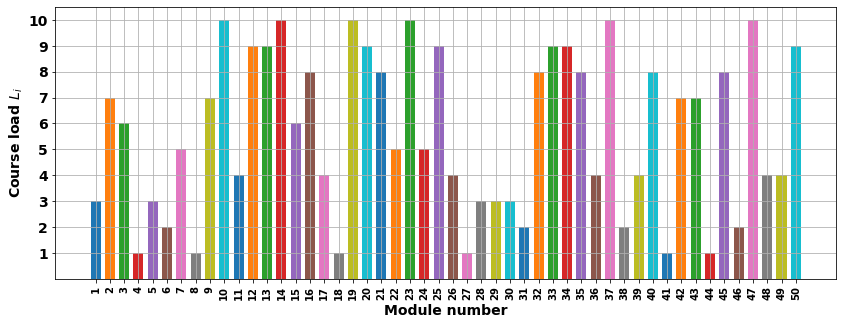

In [6]:
plt.figure(figsize=(14,5))
load = [course_load[i-1] for i in instance.i]

plt.xlabel('Module number', fontsize=14, fontweight = 'bold')
plt.ylabel('Course load $L_i$', fontsize=14, fontweight = 'bold')
T = [t for t in instance.t]
plt.yticks(T, fontsize=14, fontweight = 'bold')
A= [str(i) for i in instance.i]


Yi = [i-0.5 for i in instance.i]
for i in instance.i:
    plt.bar(i-0.5,course_load[i-1],width=0.7)

    
#plt.bar(Yi,load,width=1)
plt.xticks(Yi,A, fontsize=10, fontweight = 'bold', rotation = 90 )
plt.grid()
plt.savefig('module workload'+  ' .png', format='png', dpi=200)

plt.show()

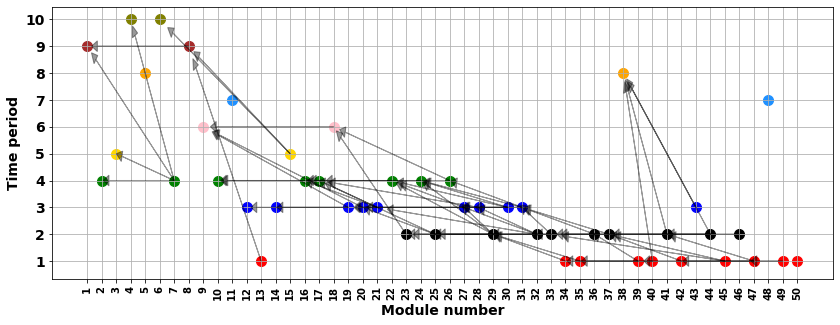

OF =  838.0


In [12]:
KOLOR = ['r', 'k', 'b', 'g', 'gold', 'pink','dodgerblue','orange','brown','olive']

loc={}
plt.figure(figsize=(14,5))
for i in instance.i:
    for t in instance.t:
        if value(instance.assign[i,t])>0:
            plt.scatter(i,t, c=KOLOR[t-1] , s= 100, label = str(i))
            loc[i]=t


    
plt.xlabel('Module number', fontsize=14, fontweight = 'bold')
plt.ylabel('Time period', fontsize=14, fontweight = 'bold')

T = [t for t in instance.t]
plt.yticks(T, fontsize=14, fontweight = 'bold')
Yi = [i for i in instance.i]
plt.xticks(Yi, fontsize=10, fontweight = 'bold', rotation = 90 )
plt.grid()
plt.savefig('Allocation OF2'+  ' .png', format='png', dpi=200)


counter = 1 
for dep in req:
    (i,j) = dep
    dx= j-i 
    dy= loc[j]-loc[i] 
    plt.arrow(i,loc[i], 0.9*dx, 0.9*dy, head_width=0.4, head_length=0.4, color='k', zorder =2, alpha = 0.4)
    plt.savefig('Allocation OF2' + str(counter)+  ' .png', format='png', dpi=200)
    counter +=1 

    #plt.plot([i,j],[loc[i],loc[j]])
    

plt.show()
print('OF = ', value(instance.obj1) )